# Setup

In [ ]:
%load_ext autoreload
%autoreload 2

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
os.getcwd()

'/Users/christellejoseph/code/Cyber_Tools/IDS'

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate
import seaborn as sns

In [6]:
csv_path = '/Users/christellejoseph/code/Cyber_Tools/IDS/data'
file_dir = os.listdir(csv_path)

In [7]:
csv_files = []
for file in file_dir:
    modified_file = file.replace('-WorkingHours', '').replace('-workingHours', '').replace(
                                        '-Afternoon', '').replace('-Morning', '').replace('.pcap_ISCX.csv', '')
    csv_files.append(modified_file)

# Merging: Dictionary Structure

In [10]:
data = {}

for name, filename in sorted(zip(csv_files, file_dir)):
    data[name] = pd.read_csv(os.path.join(csv_path, filename))

In [39]:
data['Monday'].head(2)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,49188,4,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


# Merging: Single DataFrame

In [12]:
all_data = pd.concat([pd.read_csv(os.path.join(csv_path, file)) for file in file_dir], ignore_index=True)

In [14]:
all_data.shape

(2830743, 79)

In [18]:
all_data.columns = all_data.columns.str.strip()

In [19]:
all_data['Label'].value_counts()

BENIGN                        2273097
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: Label, dtype: int64

In [42]:
all_data['Label'] = all_data['Label'].str.replace('�', '-', regex=False)


In [44]:
# all_data.to_csv('combined_df.csv', index=False)

In [23]:
all_data = all_data.drop_duplicates()

In [24]:
all_data.shape

(2522362, 79)

In [27]:
all_data.isna().sum().sort_values(ascending=False)

Flow Bytes/s            353
Destination Port          0
Bwd Avg Bytes/Bulk        0
Fwd Avg Packets/Bulk      0
Fwd Avg Bytes/Bulk        0
                       ... 
Bwd IAT Mean              0
Bwd IAT Total             0
Fwd IAT Min               0
Fwd IAT Max               0
Label                     0
Length: 79, dtype: int64

In [33]:
all_data = all_data.dropna(axis=1, how='any')

# Category Visualization

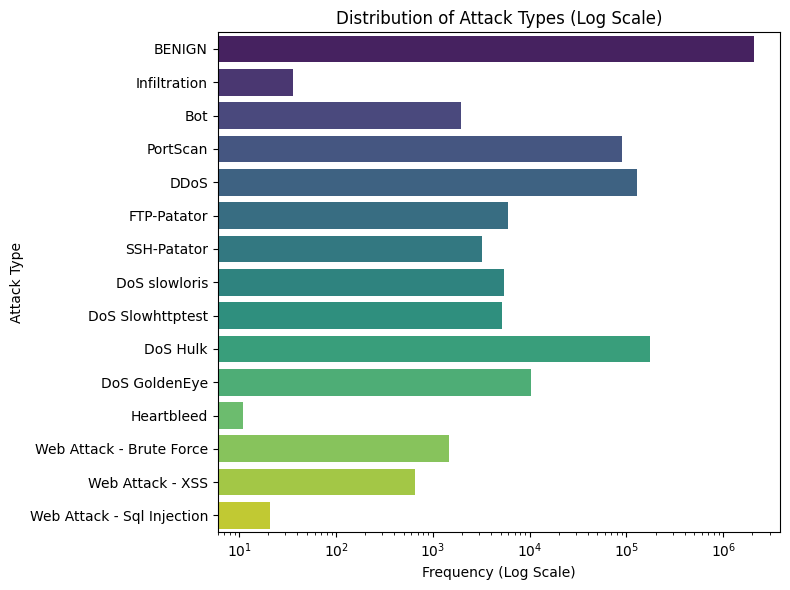

In [45]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(y='Label', data=all_data, palette='viridis')

# Set the scale of x-axis to log to better visualize the differences
ax.set_xscale('log')
plt.title('Distribution of Attack Types (Log Scale)')
plt.xlabel('Frequency (Log Scale)')
plt.ylabel('Attack Type')
plt.tight_layout()
plt.show()

# Encoder

In [54]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
all_data['EncodedLabel'] = label_encoder.fit_transform(all_data['Label'])

#Get the mapping for future reference
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

Label Mapping: {'BENIGN': 0, 'Bot': 1, 'DDoS': 2, 'DoS GoldenEye': 3, 'DoS Hulk': 4, 'DoS Slowhttptest': 5, 'DoS slowloris': 6, 'FTP-Patator': 7, 'Heartbleed': 8, 'Infiltration': 9, 'PortScan': 10, 'SSH-Patator': 11, 'Web Attack - Brute Force': 12, 'Web Attack - Sql Injection': 13, 'Web Attack - XSS': 14}


# Balancing Dataset

In [46]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from collections import Counter

In [55]:
all_data.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,EncodedLabel
0,22,166,1,1,0,0,0,0,0.0,0.0,...,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN,0
1,60148,83,1,2,0,0,0,0,0.0,0.0,...,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN,0
2,123,99947,1,1,48,48,48,48,48.0,0.0,...,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN,0
3,123,37017,1,1,48,48,48,48,48.0,0.0,...,0.000,0.000,0,0,0.0,0.000,0,0,BENIGN,0
4,0,111161336,147,0,0,0,0,0,0.0,0.0,...,1753752.625,2123197.578,4822992,95,9463032.7,2657727.996,13600000,5700287,BENIGN,0


In [58]:
#Solves - ValueError: Input X contains infinity or a value too large

all_data.replace([np.inf, -np.inf], np.nan, inplace=True)
all_data.dropna(inplace=True)

In [ ]:
X = all_data.select_dtypes(exclude='object').drop(columns = 'EncodedLabel')
y = all_data['EncodedLabel']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print("Before SMOTE:", Counter(y_train))

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

print("After SMOTE:", Counter(y_res))

Before SMOTE: Counter({0: 1571030, 4: 129538, 2: 96069, 10: 68290, 3: 7713, 7: 4420, 6: 4044, 5: 3940, 11: 2482, 1: 1447, 12: 1089, 14: 488, 9: 22, 13: 17, 8: 9})
